- https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/otto-recommender-system/sample_submission.csv
/kaggle/input/otto-recommender-system/test.jsonl
/kaggle/input/otto-recommender-system/train.jsonl


In [2]:
from pathlib import Path
import os
import random
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pwd

/kaggle/working


In [4]:
DATA_PATH = Path('../input/otto-recommender-system')
TRAIN_PATH = DATA_PATH/'train.jsonl'
TEST_PATH = DATA_PATH/'test.jsonl'
SAMPLE_SUB_PATH = Path('../input/otto-recommender-system/sample_submission.csv')

In [5]:
TRAIN_PATH

PosixPath('../input/otto-recommender-system/train.jsonl')

In [6]:
with open(TRAIN_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the training data")

We have 12,899,779 lines in the training data


# Load data

In [7]:
sample_size = 100000

# json형태의 데이터를 pd.DataFrame의 형태로 불러온다.
chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize=sample_size)

for chunk in chunks:
    sample_train_df = chunk
    break

In [8]:
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [9]:
sample_train_df.iloc[1,0]

[{'aid': 424964, 'ts': 1659304800025, 'type': 'carts'},
 {'aid': 1492293, 'ts': 1659304852871, 'type': 'clicks'},
 {'aid': 1492293, 'ts': 1659304863627, 'type': 'carts'},
 {'aid': 910862, 'ts': 1659304891923, 'type': 'clicks'},
 {'aid': 910862, 'ts': 1659304900209, 'type': 'carts'},
 {'aid': 1491172, 'ts': 1659385939248, 'type': 'clicks'},
 {'aid': 1491172, 'ts': 1659385945915, 'type': 'carts'},
 {'aid': 424964, 'ts': 1659385993848, 'type': 'clicks'},
 {'aid': 1515526, 'ts': 1659386025990, 'type': 'clicks'},
 {'aid': 440486, 'ts': 1659473014870, 'type': 'clicks'},
 {'aid': 109488, 'ts': 1659473065576, 'type': 'clicks'},
 {'aid': 1507622, 'ts': 1659473076244, 'type': 'clicks'},
 {'aid': 1734061, 'ts': 1659855882096, 'type': 'clicks'},
 {'aid': 854637, 'ts': 1659990929876, 'type': 'clicks'},
 {'aid': 854637, 'ts': 1659990941327, 'type': 'carts'},
 {'aid': 718983, 'ts': 1659990943793, 'type': 'clicks'},
 {'aid': 215311, 'ts': 1659990959575, 'type': 'clicks'},
 {'aid': 215311, 'ts': 165999

# Data의 형태
- `session` 
    - the unique session id. 
    - Each session contains a list of time ordered events.

- `events` 
    - the time ordered sequence of events in the session.
    - Each event contains 3 pieces of information: `aid`, `ts`, `type`

- `aid` 
    - the article id (product code) of the associated event

- `ts` 
    - the Unix timestamp of the event
    - (Unix time is the number of milliseconds that have elapsed since 00:00:00 UTC on 1 January 1970)

- `type` 
    - the event type, i.e., whether a product was clicked (clicks), added to the user's cart (carts), or ordered during the session (orders)

In [10]:
# Sample the first session in the df
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

This session was 276 actions long 

The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed: 27 days, 13:09:43.682000 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


# EDA

In [11]:
action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
sample_train_df.head()

,events,action_counts,article_id_counts,session_length_unix,session_length_hours,session_length_action
session,,,,,,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':...","{'clicks': 255, 'carts': 17, 'orders': 4}","{1517085: 1, 1563459: 1, 1309446: 1, 16246: 1,...",2380183682,661.162663,276
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ...","{'carts': 8, 'clicks': 24}","{424964: 2, 1492293: 2, 910862: 2, 1491172: 2,...",2410054967,669.460249,32
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ...","{'clicks': 32, 'carts': 1}","{763743: 1, 137492: 2, 504789: 1, 795863: 2, 3...",2409415621,669.282652,33
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':...","{'carts': 21, 'clicks': 200, 'orders': 5}","{1425967: 6, 1343406: 14, 1815570: 1, 287008: ...",1804866676,501.352256,226
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ...","{'clicks': 15, 'orders': 1, 'carts': 3}","{613619: 1, 298827: 2, 383828: 2, 255379: 2, 1...",2281881184,633.856392,19


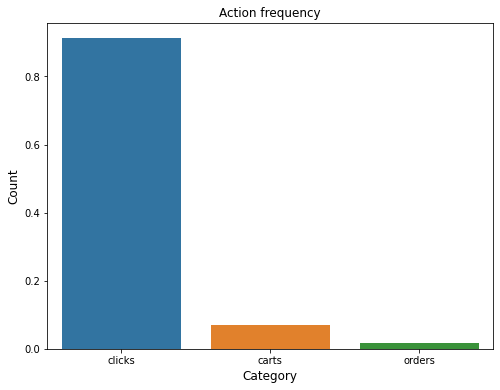

In [13]:
total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

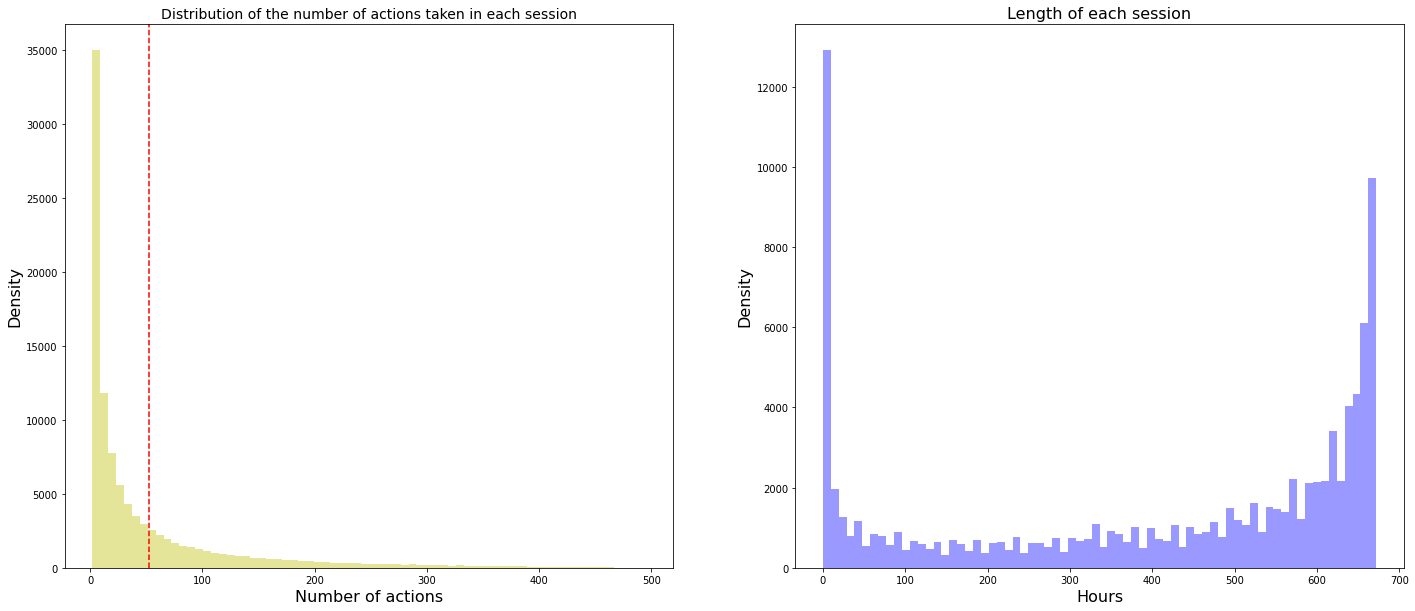

In [14]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

In [15]:
sample_train_df['session_length_action'].describe()

count    100000.00000
mean         52.27653
std          76.86172
min           2.00000
25%           6.00000
50%          19.00000
75%          63.00000
max         495.00000
Name: session_length_action, dtype: float64

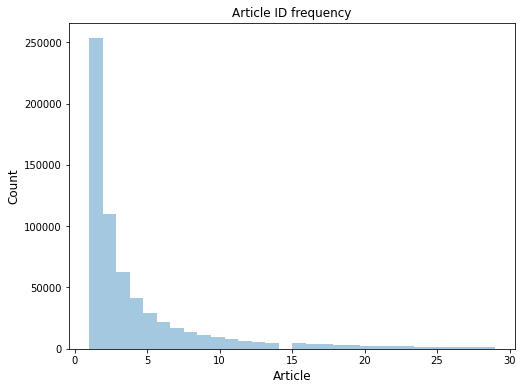

In [16]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

<AxesSubplot:ylabel='Density'>

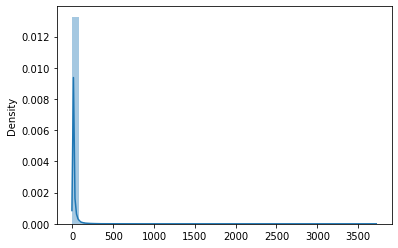

In [17]:
sns.distplot(article_id_freq)

# Baseline

In [18]:
sample_size = 150
chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

In [19]:
sample_test_df.head()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [20]:
sample_test_df.iloc[0, 1]

[{'aid': 59625, 'ts': 1661724000278, 'type': 'clicks'}]

In [21]:
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


In [22]:
sample_size = 150000
chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in enumerate(chunks):
    if e > 2:
        break
    
    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])

In [23]:
# 해당 aid list의 값을 빈도 count
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [24]:
# 상위 20개 추출
top_20_click_aid = [aid[0] for aid in article_click_freq.most_common(20)]
top_20_carts_aid = [aid[0] for aid in article_carts_freq.most_common(20)]
top_20_order_aid = [aid[0] for aid in article_order_freq.most_common(20)]

In [25]:
frequent_articles = {'clicks': top_20_click_aid, 'carts':top_20_carts_aid, 'order':top_20_order_aid}

In [26]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)
preds = []

for chunk in tqdm(test_data, total=1671):
    for i, row in chunk.iterrows():
        actions = row['events']
        aid_list = []
        for action in actions:
            aid_list.append(action['aid'])
            
        article_freq = Counter(aid_list)
        top_articles = nlargest(20, article_freq, key=article_freq.get)
        
        padding_size = 20 - len(top_articles)
        for action in ['clicks','carts','order']:
            top_articles = top_articles + frequent_articles[action][-padding_size:]
            preds.append(" ".join([str(id) for id in top_articles]))

  0%|          | 0/1671 [00:00<?, ?it/s]

In [27]:
sample_submission['labels'] = preds
sample_submission.to_csv('submission.csv', index=False)